In [6]:
#libraries
from __future__ import division
import numpy as np
import os
import glob

from random import *
from PIL import Image
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.image as mpimg

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU, Activation, BatchNormalization
from keras.layers.convolutional import Convolution2D, Cropping2D, ZeroPadding2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Adam, RMSprop
from google.colab import drive

In [7]:
#create a dictionary
drive.mount('/content/gdrive')
d={}
from subprocess import check_output
with open('gdrive/My Drive/test.txt') as f:
  for line in f:
    key=line.split(' ')[0]
    writer=line.split(' ')[2]
    #print(key, " :: ", writer)
    d[key]=writer
print(len(d.keys()))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
3


(38,)
(38,)


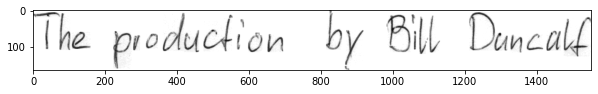

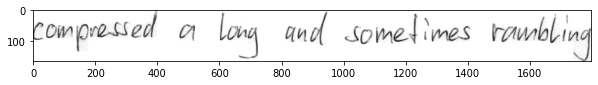

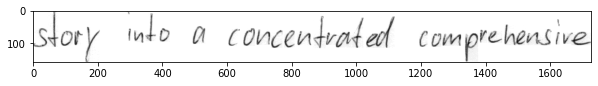

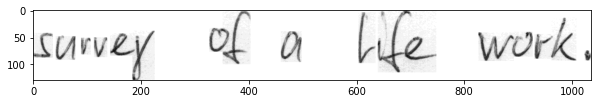

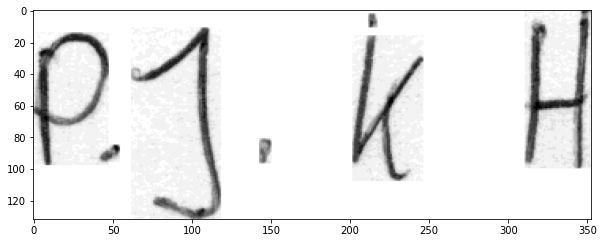

In [8]:
#filenames list and target_writer names list are created
tmp=[]
target_list=[]

path_to_files=os.path.join('gdrive/My Drive/test', '*')
for filename in sorted(glob.glob(path_to_files)):
  #print(filename)
  tmp.append(filename)
  image_name=filename.split('/')[-1]
  file,ext=os.path.splitext(image_name)
  parts=file.split('-')
  form=parts[0]+'-'+parts[1]
  for key in d:
    if key == form:
      target_list.append(str(d[form]))

img_files=np.asarray(tmp)
img_targets=np.asarray(target_list)
print(img_files.shape)
print(img_targets.shape)

for filename in img_files[:5]:
  img=mpimg.imread(filename)
  plt.figure(figsize=(10,10))
  plt.imshow(img,cmap='gray')

In [9]:
#normalization
encoder=LabelEncoder()
encoder.fit(img_targets)
encoded_Y=encoder.transform(img_targets)

print(img_files[:5],img_targets[:5],encoded_Y[:5])

['gdrive/My Drive/test/c01-009-s00-00.png'
 'gdrive/My Drive/test/c01-009-s00-01.png'
 'gdrive/My Drive/test/c01-009-s00-02.png'
 'gdrive/My Drive/test/c01-009-s00-03.png'
 'gdrive/My Drive/test/c01-009-s01-00.png'] ['4' '4' '4' '4' '4'] [2 2 2 2 2]


In [10]:
#splitting of data into training and validation sets for cross-validation (4:1:1)
train_files, rem_files, train_targets, rem_targets=train_test_split(img_files, encoded_Y, train_size=0.66, random_state=52, shuffle= True)

validation_files, test_files, validation_targets, test_targets=train_test_split(rem_files, rem_targets, train_size=0.5, random_state=22, shuffle= True)

print(train_files.shape, validation_files.shape, test_files.shape)
print(train_targets.shape, validation_targets.shape, test_targets.shape)


(25,) (6,) (7,)
(25,) (6,) (7,)


In [11]:
#input to model
#generator function implicated to make patches and to generate random crops from each sentence
#now generators for randomly cropping patches from this images

batch_size=16
num_classes=50

#start with train generator
def generate_data(samples,target_files,batch_size=batch_size,factor=0.1):
  num_samples=len(samples)
  from sklearn.utils import shuffle
  while 1:
    for offset in range(0,num_samples,batch_size):
      batch_samples=samples[offset:offset+batch_size]
      batch_targets=target_files[offset:offset+batch_size]

      images=[]
      targets=[]
      for i in range(len(batch_samples)):
        batch_sample=batch_samples[i]
        batch_target=batch_targets[i]
        im=Image.open(batch_sample)
        cur_width=im.size[0]
        cur_height=im.size[1]

        height_fac=113/cur_height

        new_width=int(cur_width*height_fac)
        size=new_width, 113

        imresize=im.resize((size),Image.ANTIALIAS)
        now_width=imresize.size[0]
        now_height=imresize.size[1]

        avail_x_points=list(range(0, now_width - 113))

        pick_num=int(len(avail_x_points)*factor)

        random_startx=sample(avail_x_points,pick_num)

        for start in random_startx:
          imcrop=imresize.crop((start,0,start+113,113))
          images.append(np.asarray(imcrop))
          targets.append(batch_target)

      X_train=np.array(images)
      y_train=np.array(targets)

      X_train=X_train.reshape(X_train.shape[0],113,113,1)

      X_train=X_train.astype('float32')
      X_train/=255

      y_train=to_categorical(y_train,num_classes)
      yield shuffle(X_train, y_train)

  
train_generator=generate_data(train_files, train_targets, batch_size=batch_size, factor=0.3)
validation_generator=generate_data(validation_files, validation_targets, batch_size=batch_size, factor=0.3)
test_generator=generate_data(test_files, test_targets, batch_size=batch_size, factor=0.1)



In [12]:
#keras model
def resize_image(image):
  import tensorflow as tf 
  return tf.image.resize(image,[56,56])

row, col, ch=113, 113, 1

model=Sequential()
model.add(ZeroPadding2D((1,1), input_shape=(row, col, ch)))

model.add(Lambda(resize_image))

#CNN model
model.add(Convolution2D(filters=32, kernel_size=(5,5), strides=(2,2), padding='same', name= 'conv1'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),name='pool1'))

model.add(Convolution2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', name= 'conv2'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),name='pool2'))

model.add(Convolution2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', name= 'conv3'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),name='pool3'))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(128, name='dense1'))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(64, name='dense2'))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes,name='output'))
model.add(Activation('softmax'))
print("Workout till here")

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

print(model.summary())



Workout till here
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 115, 115, 1)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 56, 56, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 28, 28, 32)        832       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 14, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None,

In [13]:
#training model
nb_epoch = 4
samples_per_epoch = 233
nb_val_samples = 47

#save model using keras
from keras.callbacks import ModelCheckpoint
filepath="gdrive/My Drive/check-{epoch:02d}-{val_loss:.4f}.hdf5"
#checkpoint2/check-{epoch:02d} - {val_loss:.4f}.hdf5"

checkpoint = ModelCheckpoint(filepath=filepath,verbose=1, save_best_only=False)
callbacks_list=[checkpoint]

#model fit generator
#history_object = model.fit_generator(train_generator, samples_per_epoch = samples_per_epoch, validation_data = validation_generator, nb_val_samples = nb_val_samples, nb_epoch = nb_epoch, verbose=1, callbacks = callbacks_list)
history_object = model.fit_generator(train_generator,  steps_per_epoch=samples_per_epoch, validation_data=validation_generator, validation_steps=nb_val_samples, epochs=nb_epoch, verbose=1, callbacks=callbacks_list)


Epoch 1/4
233/233 [==============================] - 2391s 10s/step - loss: 1.0885 - accuracy: 0.4962 - val_loss: 0.4360 - val_accuracy: 0.5762

Epoch 00001: saving model to gdrive/My Drive/check-01-0.4360.hdf5
Epoch 2/4
233/233 [==============================] - 2393s 10s/step - loss: 0.4298 - accuracy: 0.7291 - val_loss: 0.4324 - val_accuracy: 0.6436

Epoch 00002: saving model to gdrive/My Drive/check-02-0.4324.hdf5
Epoch 3/4
233/233 [==============================] - 2360s 10s/step - loss: 1.0526 - accuracy: 0.4638 - val_loss: 0.7788 - val_accuracy: 0.4899

Epoch 00003: saving model to gdrive/My Drive/check-03-0.7788.hdf5
Epoch 4/4
233/233 [==============================] - 2349s 10s/step - loss: 0.5980 - accuracy: 0.6669 - val_loss: 0.4308 - val_accuracy: 0.5744

Epoch 00004: saving model to gdrive/My Drive/check-04-0.4308.hdf5


Testing

In [16]:
model.load_weights('gdrive/My Drive/check-02-0.4324.hdf5')

scores = model.evaluate_generator(test_generator,121) 
print("Accuracy = ", scores[1])

Accuracy =  0.763201892375946


In [17]:
images = []
for filename in test_files[:50]:
     im = Image.open(filename)

     cur_width = im.size[0]
     cur_height = im.size[1]

     print("Before Crop:", cur_width, cur_height)
     height_fac = 113 / cur_height

     new_width = int(cur_width * height_fac)
     size = new_width, 113

     imresize = im.resize((size), Image.ANTIALIAS)  # Resize so height = 113 while keeping aspect ratio
     now_width = imresize.size[0]
     now_height = imresize.size[1]
     print("After Crop:", now_width, now_height)
#     # Generate crops of size 113x113 from this resized image and keep random 10% of crops

     avail_x_points = list(range(0, now_width - 113 ))# total x start points are from 0 to width -113

#     # Pick random x%
     factor = 0.1
     pick_num = int(len(avail_x_points)*factor)
     print("Pick Number is ::", pick_num)
    
     random_startx = sample(avail_x_points,  pick_num)

     for start in random_startx:
         imcrop = imresize.crop((start, 0, start+113, 113))
         images.append(np.asarray(imcrop))
         
     X_test = np.array(images)
    
     X_test = X_test.reshape(X_test.shape[0], 113, 113, 1)
#     #convert to float and normalize
     X_test = X_test.astype('float32')
     X_test /= 255
     shuffle(X_test)

print(X_test.shape)

Before Crop: 1151 77
After Crop: 1689 113
Pick Number is :: 157
Before Crop: 1617 144
After Crop: 1268 113
Pick Number is :: 115
Before Crop: 1729 164
After Crop: 1191 113
Pick Number is :: 107
Before Crop: 213 97
After Crop: 248 113
Pick Number is :: 13
Before Crop: 200 127
After Crop: 177 113
Pick Number is :: 6
Before Crop: 353 132
After Crop: 302 113
Pick Number is :: 18
Before Crop: 1804 146
After Crop: 1396 113
Pick Number is :: 128
(544, 113, 113, 1)


544/544 [==============================] - 1s 1ms/step
(544, 50)
544


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

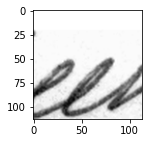

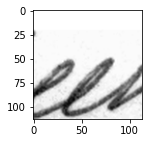

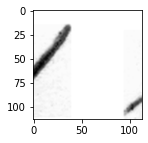

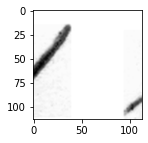

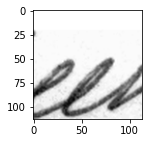

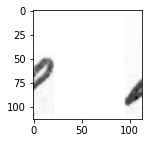

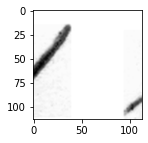

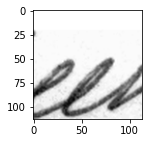

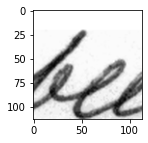

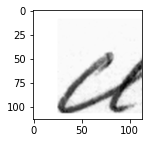

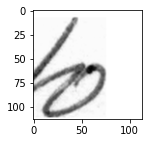

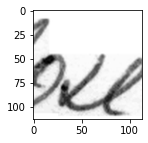

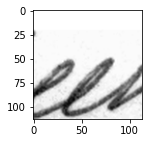

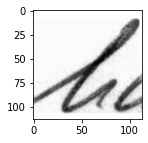

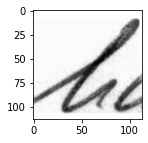

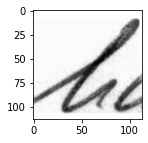

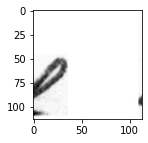

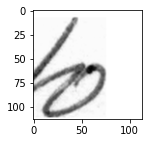

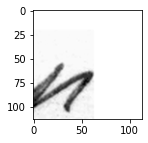

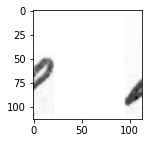

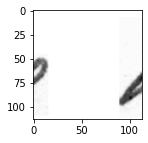

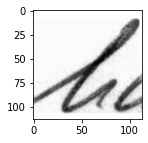

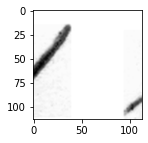

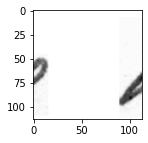

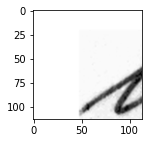

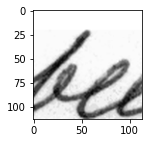

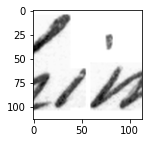

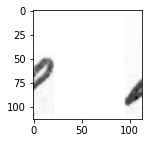

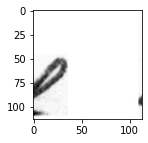

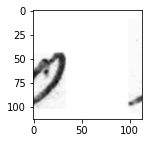

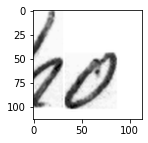

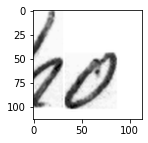

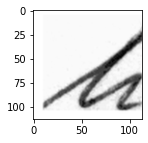

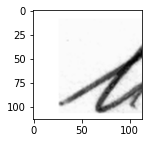

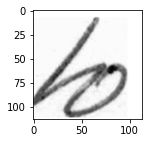

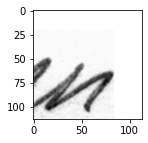

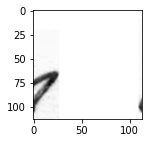

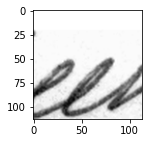

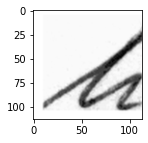

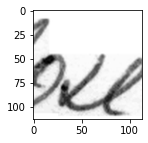

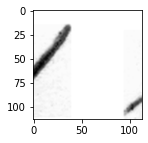

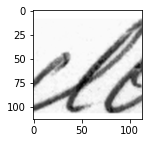

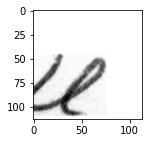

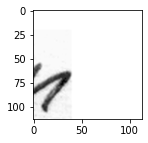

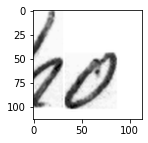

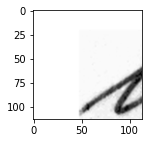

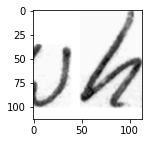

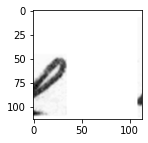

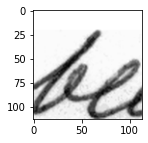

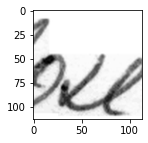

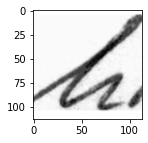

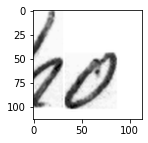

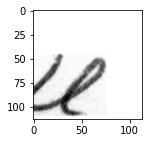

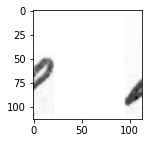

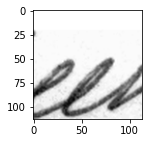

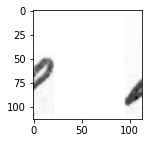

In [18]:
# Creating the predictive model

predictions = model.predict(X_test, verbose =1)

print(predictions.shape)
predicted_writer = []
for pred in predictions:
     predicted_writer.append(np.argmax(pred))
print(len(predicted_writer))

writer_number = 0
total_image = 20
counter = 0

for i in range(len(predicted_writer)//10):
  if predicted_writer[i] == writer_number:
    image= X_test[i].squeeze()
    plt.figure(figsize=(2,2))
    plt.imshow(image, cmap='gray')
#print(X_test[1])
image1 = X_test[0].squeeze()
image2 = X_test[1].squeeze()

plt.figure(figsize=(2,2))
plt.imshow(image1, cmap = 'gray')

plt.figure(figsize=(2,2))
plt.imshow(image, cmap = 'gray')